Homework - Mamdani Fuzzy System Modeling
Number of partitions for each input variable: 7

--- Results for F1 (sinc-based function) ---
Crisp mode → FVU: 0.1156, PCC: 0.9480
Fuzzy mode → FVU: 0.1386, PCC: 0.9429


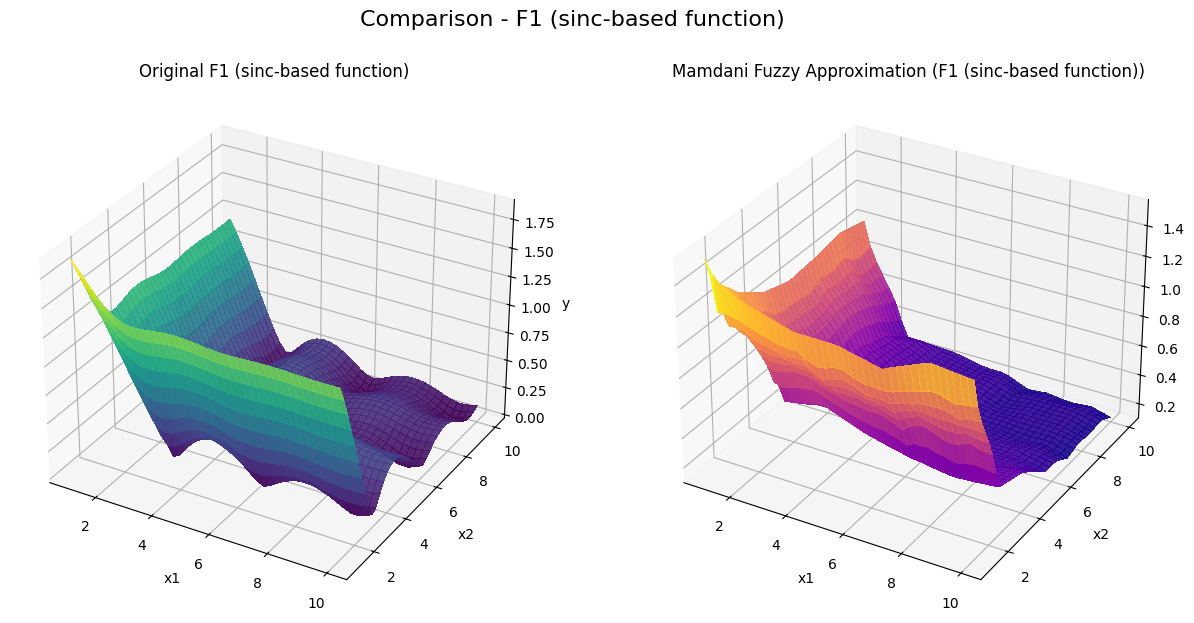

--- Results for F2 (polynomial function) ---
Crisp mode → FVU: 0.1047, PCC: 0.9488
Fuzzy mode → FVU: 0.1630, PCC: 0.9437


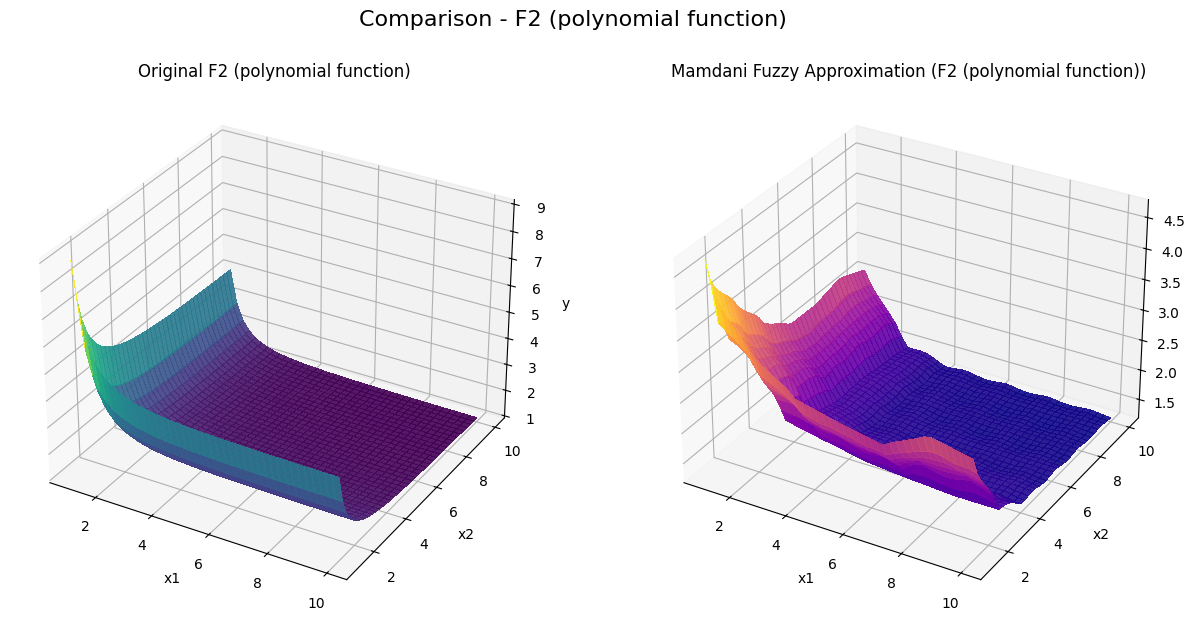


All done! Plots are saved in the 'plots' folder.


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import os

# -------------------------------
# 1. Definition of the two functions
# -------------------------------
def F1(x1, x2):
    return np.sqrt(2 * (np.sin(x1)/x1)**2 + 3 * (np.sin(x2)/x2)**2)

def F2(x1, x2):
    return (1 + x1**(-2) + x2**(-1.5))**2

# -------------------------------
# 2. Evaluation metrics
# -------------------------------
def FVU(y_true, y_pred):
    return np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)

def PCC(y_true, y_pred):
    if len(y_true) == 0:
        return 0.0
    return np.corrcoef(y_true, y_pred)[0, 1]

# -------------------------------
# 3. Mamdani Fuzzy Inference System
# -------------------------------
class MamdaniFIS:
    def __init__(self, n_partitions=7, mode='crisp'):
        self.n_partitions = n_partitions
        self.mode = mode                     # 'crisp' or 'fuzzy'
        self.centers = np.linspace(1, 10, n_partitions)
        self.width = (10 - 1) / (n_partitions - 1) if n_partitions > 1 else 9.0
        self.rules = None

    def triangular_mf(self, x, a, b, c):
        return np.maximum(0, np.minimum((x - a)/(b - a + 1e-12), (c - x)/(c - b + 1e-12)))

    def membership(self, value):
        mu = []
        for c in self.centers:
            left  = max(0, (value - (c - self.width)) / self.width)
            right = max(0, ((c + self.width) - value) / self.width)
            mu.append(min(left, right))
        return np.array(mu)

    def train(self, X_train, y_train):
        rule_sum   = np.zeros((self.n_partitions, self.n_partitions))
        rule_count = np.zeros((self.n_partitions, self.n_partitions))

        for i in range(len(X_train)):
            mu1 = self.membership(X_train[i, 0])
            mu2 = self.membership(X_train[i, 1])
            idx1 = np.argmax(mu1)
            idx2 = np.argmax(mu2)
            rule_sum[idx1, idx2]   += y_train[i]
            rule_count[idx1, idx2] += 1

        self.rules = np.where(rule_count > 0,
                              rule_sum / rule_count,
                              np.mean(y_train))

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            mu1 = self.membership(x[0])
            mu2 = self.membership(x[1])

            if self.mode == 'crisp':
                num = den = 0.0
                for i in range(self.n_partitions):
                    for j in range(self.n_partitions):
                        fire = min(mu1[i], mu2[j])
                        num += fire * self.rules[i, j]
                        den += fire
                pred = num / den if den > 0 else np.mean(self.rules)

            else:  # fuzzy mode with centroid defuzzification
                y_min = np.min(self.rules)
                y_max = np.max(self.rules)
                y_range = np.linspace(y_min, y_max, 100)
                aggregated = np.zeros_like(y_range)
                out_width = (y_max - y_min) / self.n_partitions if y_max > y_min else 1.0

                for i in range(self.n_partitions):
                    for j in range(self.n_partitions):
                        fire = min(mu1[i], mu2[j])
                        if fire > 0:
                            c = self.rules[i, j]
                            mf = self.triangular_mf(y_range,
                                                    c - out_width,
                                                    c,
                                                    c + out_width)
                            aggregated = np.maximum(aggregated, np.minimum(fire, mf))

                if np.sum(aggregated) > 0:
                    pred = np.sum(y_range * aggregated) / np.sum(aggregated)
                else:
                    pred = np.mean(self.rules)

            predictions.append(pred)
        return np.array(predictions)

# -------------------------------
# 4. Main execution
# -------------------------------
if __name__ == "__main__":
    np.random.seed(42)

    # Generate 800 random data points
    X = np.random.uniform(1, 10, size=(800, 2))

    functions = [F1, F2]
    names = ["F1 (sinc-based function)", "F2 (polynomial function)"]

    print("Homework - Mamdani Fuzzy System Modeling")
    print("Number of partitions for each input variable: 7\n")

    # Create folder for saving plots
    if not os.path.exists("plots"):
        os.makedirs("plots")

    for func, name in zip(functions, names):
        y = func(X[:, 0], X[:, 1])

        # 70% train, 30% test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        print(f"--- Results for {name} ---")

        # Evaluate both modes
        for mode in ['crisp', 'fuzzy']:
            model = MamdaniFIS(n_partitions=7, mode=mode)
            model.train(X_train, y_train)
            y_pred = model.predict(X_test)

            fvu_val = FVU(y_test, y_pred)
            pcc_val = PCC(y_test, y_pred)

            print(f"{mode.capitalize()} mode → FVU: {fvu_val:.4f}, PCC: {pcc_val:.4f}")

        # Visualization (using fuzzy mode)
        model_vis = MamdaniFIS(n_partitions=7, mode='fuzzy')
        model_vis.train(X_train, y_train)

        # Grid for 3D surface
        res = 40
        x1_grid = np.linspace(1, 10, res)
        x2_grid = np.linspace(1, 10, res)
        X1, X2 = np.meshgrid(x1_grid, x2_grid)

        Z_true = func(X1, X2)
        grid_points = np.column_stack([X1.ravel(), X2.ravel()])
        Z_pred = model_vis.predict(grid_points).reshape(X1.shape)

        # Plot
        fig = plt.figure(figsize=(15, 7))
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.plot_surface(X1, X2, Z_true, cmap='viridis', linewidth=0, antialiased=False, alpha=0.9)
        ax1.set_title(f"Original {name}")
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')

        ax2 = fig.add_subplot(122, projection='3d')
        ax2.plot_surface(X1, X2, Z_pred, cmap='plasma', linewidth=0, antialiased=False, alpha=0.9)
        ax2.set_title(f"Mamdani Fuzzy Approximation ({name})")
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')

        plt.suptitle(f"Comparison - {name}", fontsize=16)
        plot_path = f"plots/comparison_{name.split()[0]}.png"
        plt.savefig(plot_path, dpi=200, bbox_inches='tight')
        plt.show()

    print("\nAll done! Plots are saved in the 'plots' folder.")